# Assignment 3: Convolutional Neural Networks
Sarah Whelan (250778849), Dana Zagar (250790176) via Colab

The problem we are modelling is the classification of clothing items using the Fashion MNIST dataset from Kaggle. We will be using convolutional neural networks to achieve an accuracy of around 88.5%.

Setting up the environment with the required imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


Retrieving and loading the data (just copied data to local runtime).

In [0]:
# Get data files
training_set = "/content/fashion-mnist_train.csv"
test_set = "/content/fashion-mnist_test.csv"

In [0]:
# Splitting data into training and validation sets, to evaluate
# the model's performance.
raw_training = np.loadtxt(training_set, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(raw_training[:,1:], raw_training[:,0], test_size=0.1)

Let's plot the first element of the training set to get an idea of how our CNN will be convoluting our input set.

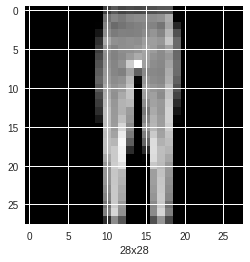

In [4]:
plt.xlabel('28x28')
plt.imshow(x_train[0].reshape(28,28), cmap='gray')

Keras wants an additional dimension to reshape all of the data in this way; since the dataset is all grayscale images, there is only one channel so we will use 1.

In [0]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

To allow the net to converge faster, we can normalize the pixel values to be between 0 and 1 (versus 0 to 255).

In [0]:
x_train = x_train.astype("float32")/255
x_val = x_val.astype("float32")/255

The labels of the 10 classes are given as integers between 0 and 9. Converting the labels to "one-hot encoding" (i.e. 10x1 array with one 1 and nine zeroes, and the position of 1 shows us the value) will be necessary to interpret the data properly. 

In [0]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

To train the model, we can use the Keras Sequential API that will let us add one layer at a time. We will start with the input layer, and then add convolutional layers (Conv2D), max pooling layers (MaxPooling), batch normalization (BatchNormalization), and dropout (Dropout).


*   Conv2D: use weights to transform a pixel to a weighted average of itself as well as its eight neighbouring pixels.
*   MaxPool2D: views the four neighbouring pixels and picks the maximum value, reducing the image size by half
*  BatchNormalization: applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
*  Dropout: a regularization method where the layer randomly replaces a proportion of its weights to 0 for each training sample; this forces learning in a more distributed fashion instead of relying on a specific weight, which improves the net's generalization. Hurrah for avoiding overfitting!



In [0]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size= (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size= (3,3), activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))


Adding more layers to the model: flattening, then feeding through several densely-connected neural network layers. The use of the 'softmax' activation on the last Dense layer is explained further below.

In [0]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

To improve our model's ability to generalize, data augmentation is essential. To augment the data, we can use the built-in Keras function. We won't augment the data too much, since the images are only 28x28 pixels and we don't want to destroy the integrity of the shapes contained within the image as far as to mislead our model.

In [0]:
img_data_gen = ImageDataGenerator(zoom_range=0.1, shear_range=0.1, height_shift_range=0.1, width_shift_range=0.1, rotation_range=10, vertical_flip=True)

When compiling the model, we dictate the loss function to be used as well as the optimizer. For the loss function, we will use the 'categorical_crossentropy' loss function, which is a good loss function for multi-class cross-entropy when inferring maximum likelihood. It requires that our output layer is configured with one node for each class and a 'softmax' activation to predict the probability for each class, which we have set up previously. For the optimizer, we will use Adam.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer= Adam(lr=1e-4), metrics=["accuracy"])

Let's generate a summary of our model to neatly view our layers with their associated output shape and number of parameters.

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_41 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization_42 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 22, 22, 16)        2320      
_________________________________________________________________
batch_normalization_43 (Batc (None, 22, 22, 16)        64        
_________________________________________________________________
dropout_13 (Dropout)         (None, 22, 22, 16)        0         
__________

A nifty feature that Keras provides is the ability to speed up each epoch by reducing our learning rate by 5% each time.

In [0]:
lr_decay = LearningRateScheduler(lambda x: 0.95**x * 1e-3)

Training time!
We will use the data augmentation generator we defined above to feed the network. The validation data we will train on will be a subset of the validation data we originally defined, to speed up the training process. We will use 50 epochs, which had a runtime of about an hour and a half. We tweaked the number of epochs and the batch size several times, and these settings provided the best accuracy for our model.

In [22]:
model_history = model.fit_generator(img_data_gen.flow(x_train, y_train, batch_size=32),
                                   steps_per_epoch=500,
                                   epochs=50,
                                   verbose=2,
                                   validation_data=(x_val[:400,:], y_val[:400,:]),
                                   callbacks=[lr_decay])

Epoch 1/50
 - 120s - loss: 0.7809 - acc: 0.7146 - val_loss: 0.5895 - val_acc: 0.7650
Epoch 2/50
 - 120s - loss: 0.7114 - acc: 0.7449 - val_loss: 0.5707 - val_acc: 0.7875
Epoch 3/50
 - 120s - loss: 0.6912 - acc: 0.7511 - val_loss: 0.5339 - val_acc: 0.7750
Epoch 4/50
 - 120s - loss: 0.6544 - acc: 0.7670 - val_loss: 0.5246 - val_acc: 0.7925
Epoch 5/50
 - 120s - loss: 0.6256 - acc: 0.7798 - val_loss: 0.4464 - val_acc: 0.8150
Epoch 6/50
 - 120s - loss: 0.6105 - acc: 0.7845 - val_loss: 0.4710 - val_acc: 0.8225
Epoch 7/50
 - 119s - loss: 0.5997 - acc: 0.7872 - val_loss: 0.4245 - val_acc: 0.8325
Epoch 8/50
 - 119s - loss: 0.5876 - acc: 0.7903 - val_loss: 0.5607 - val_acc: 0.7900
Epoch 9/50
 - 121s - loss: 0.5629 - acc: 0.7958 - val_loss: 0.4866 - val_acc: 0.8100
Epoch 10/50
 - 119s - loss: 0.5578 - acc: 0.8009 - val_loss: 0.3944 - val_acc: 0.8425
Epoch 11/50
 - 119s - loss: 0.5425 - acc: 0.8052 - val_loss: 0.4063 - val_acc: 0.8500
Epoch 12/50
 - 119s - loss: 0.5266 - acc: 0.8127 - val_loss: 0.

Let's evaluate on the entire validation set.

In [23]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.3073, final accuracy: 0.8835


With the validation set, our model reports approximately 0.8835 for final accuracy and 0.3073 for final loss.

To visualize the performance of the model, let's plot the accuracy and loss for both the training and validation sets.

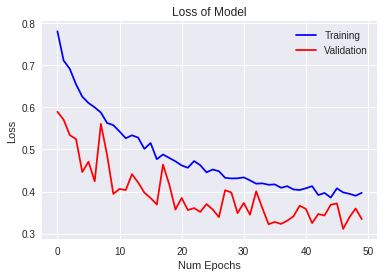

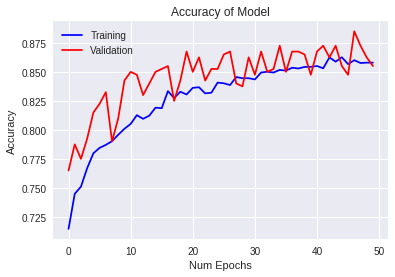

In [24]:
plt.plot(model_history.history['loss'], color='b')
plt.plot(model_history.history['val_loss'], color='r')
plt.title('Loss of Model')
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()
plt.plot(model_history.history['acc'], color='b')
plt.plot(model_history.history['val_acc'], color='r')
plt.title('Accuracy of Model')
plt.xlabel('Num Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

To test our model with the test data provided, we will split out the label (result) of the photo from its 784 associated pixel values, shape the pixel value set and then evaluate the model using these two sets. 

In [25]:
raw_test = np.loadtxt(test_set, skiprows=1, dtype='int', delimiter=',')
x_test= raw_test[:, 1:]
y_test = to_categorical(raw_test[:,0])
x_test = x_test.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255
score = model.evaluate(x_test, y_test)
print("Loss: {:.4f}".format(score[0]))
print("Accuracy: {:.4f}".format(score[1]))

10000/10000 [==============================] - 19s 2ms/step
Loss: 0.3036
Accuracy: 0.8854


When we ran the model through, we achieved an accuracy score of 0.8854 and a loss of 0.3036 over the 10000 photos provided in the test set. To achieve a higher score, we could add additional layers to our network, increase the number of epochs, and tweak other parameters when building our layers and compiling our model.